# python script for reading bmmflux output

- Test script for quick-looking bmmflux output based on W. Babel's R scripts
- Should be a good start for reading the bmmflux output for the VHSRE
- Store this script for posteriority in the DTS git repo.
- Original version can be found in the bmmflux folder

In [1]:
# netcdf/numpy/xray/stats
import numpy as np
from datetime import datetime, timedelta
import pandas as pd
import xarray as xr
from scipy.stats.stats import pearsonr

# OS interaction
import sys
import pickle
import os

# import plotting
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.basemap import Basemap
import kgraph

# Customize
sns.set_style("whitegrid")
sns.set_context('paper')
%matplotlib inline

In [2]:
# ------------------------------------------------------------------------------------------
# Directory Lists

# Find host name
import socket
if socket.gethostname().find('.')>=0:
    name=socket.gethostname()
else:
    name=socket.gethostbyaddr(socket.gethostname())[0]

# Determine which machine the script is running on; set up directory names
if 'btgmm8' in name:
    dirPre = '/Users/karllapo/Desktop/proj/VertHarpExp2017Kloendeel/'
elif 'klapos' in name:
    dirPre = '/Users/karllapo/gdrive/DarkMix/proj/VertHarpExp2017Kloendeel/'

dirData = dirPre + 'data/land_station_eddycovar_2m/results/VHSRE/'
dirPrint = dirPre + 'graphics'
dirProcessed = dirPre + 'data/land_station_eddycovar_2m_processed/'

In [8]:
# In order to keep bmmflux from crashing I had to break the analyis up into
# chunks. Each chunk is labeled according to the time period (DOY) that it covers.
filenameSuffix = ['247', '247_5', '248', '248_5']
os.chdir(dirData)


In [4]:
# Convert MATLAB datenum to numpy datetime 64
def matlabdn2datetime(matlabDatenum):
    npDatetime = [np.datetime64(datetime.fromordinal(int(dt))\
                                + timedelta(days=float(np.remainder(dt,1)))\
                                - timedelta(days = 366))\
                    for dt in matlabDatenum]        
    return(npDatetime)

## Formatting the conditional surface fluxes
- I must have done something in the parameter files to have this turned off. My guess this occured when I disabled the covariance spectrum between w' and the gas analysis.

In [5]:
# os.chdir(dirData)
# condFlux = pd.read_csv('VHSRE_filestatistics_1s_3Drot_frc_DOY247_5.csv',
#                        header=[0, 1], delimiter=',', index_col=2)
# condFlux.drop(condFlux.columns.values[0:4], axis=1, inplace=True)

# # Drop first row (just contains units), save as separate dictionary
# condFlux_units = {}
# for cfNames in condFlux.columns:
#     condFlux_units[cfNames[0]] = cfNames[1]
#     if '[1]' in cfNames:
#         condFlux_units[cfNames[0]] = 'unitless'

# # Format column names (remove weird tuples)
# condFlux.columns = [cfNames[0] for cfNames in condFlux.columns]

# # Convert MATLAB serial date number to datetime64 format
# condFlux = condFlux.reset_index(drop=True).set_index([matlabdn2datetime(condFlux.index.values)])

# # Create lists of observations and QC fields for plotting
# qcItems = [cf for cf in condFlux_units if 'unitless' in condFlux_units[cf]]
# obsItems = [cf for cf in condFlux_units if not 'unitless' in condFlux_units[cf]]

# # Convert to xarray Dataset
# condFlux_ds = xr.Dataset.from_dataframe(condFlux)
# condFlux_ds.rename({'index': 'time'}, inplace=True);
# condFlux_ds.attrs = condFlux_units


In [6]:
# fig, axes = plt.subplots(6, 3, sharex=True, figsize=(15, 15))
# axes = axes.flatten()
# for n, obs in enumerate(obsItems):
#     ax = axes[n]
#     ax.plot(condFlux.index, condFlux[obs])
#     ax.set_ylabel(obs + condFlux_units[obs])
#     ax.set_title(obs)
# fig.autofmt_xdate()
# fig.tight_layout()


## Formatting the filestatistics

In [9]:
allFileStats = ['VHSRE_filestatistics_1s_3Drot_frc_DOY' + str(DOY) + '.csv'
                for DOY in filenameSuffix]
fStats = pd.DataFrame()
fStats_list = []
for files in allFileStats:
    df = pd.read_csv(files, header=[0, 1], delimiter=',',
                                    index_col=1, parse_dates=[1])
    # Drop datetime_end column
    df.drop(df.columns.values[1], axis=1, inplace=True)
    fStats_list.append(df)
fStats = pd.concat(fStats_list)

# All columns are unitless, drop units row. I'm using a super hacky approach,
# it would be good to clean this up later.
fStats.rename(index=str, columns={fStats.columns[0]: 'Filename'}, inplace=True)
fStats.columns = [fS[0] for fS in fStats.columns]
fStats.rename(index=str, columns={fStats.columns[0]: 'Filename'}, inplace=True)

## Formatting QA/QC

In [10]:
all_qaqc = ['VHSRE_qaqc_1s_3Drot_frc_DOY' + str(DOY) + '.csv'
            for DOY in filenameSuffix]
qaqc_df = pd.DataFrame()
qaqc_list = []
for qFiles in all_qaqc:
    print(qFiles)
    df = pd.read_csv(qFiles, header=0, delimiter=',', index_col='Datetime_center')
    # Drop datetime_end column
    df.drop(['Datetime_start', 'Datetime_end', 'DOY'], axis=1, inplace=True)
    df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
    qaqc_list.append(df)
qaqc_df = pd.concat(qaqc_list)

# Save units as separate dictionary
qaqc_units = qaqc_df.iloc[0]
for qu in qaqc_units.keys():
    if '[1]' in qaqc_units[qu]:
        qaqc_units[qu] = 'unitless'
qaqc_df.drop([qaqc_df.index[0]], inplace=True)


VHSRE_qaqc_1s_3Drot_frc_DOY247.csv


/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


VHSRE_qaqc_1s_3Drot_frc_DOY247_5.csv
VHSRE_qaqc_1s_3Drot_frc_DOY248.csv
VHSRE_qaqc_1s_3Drot_frc_DOY248_5.csv


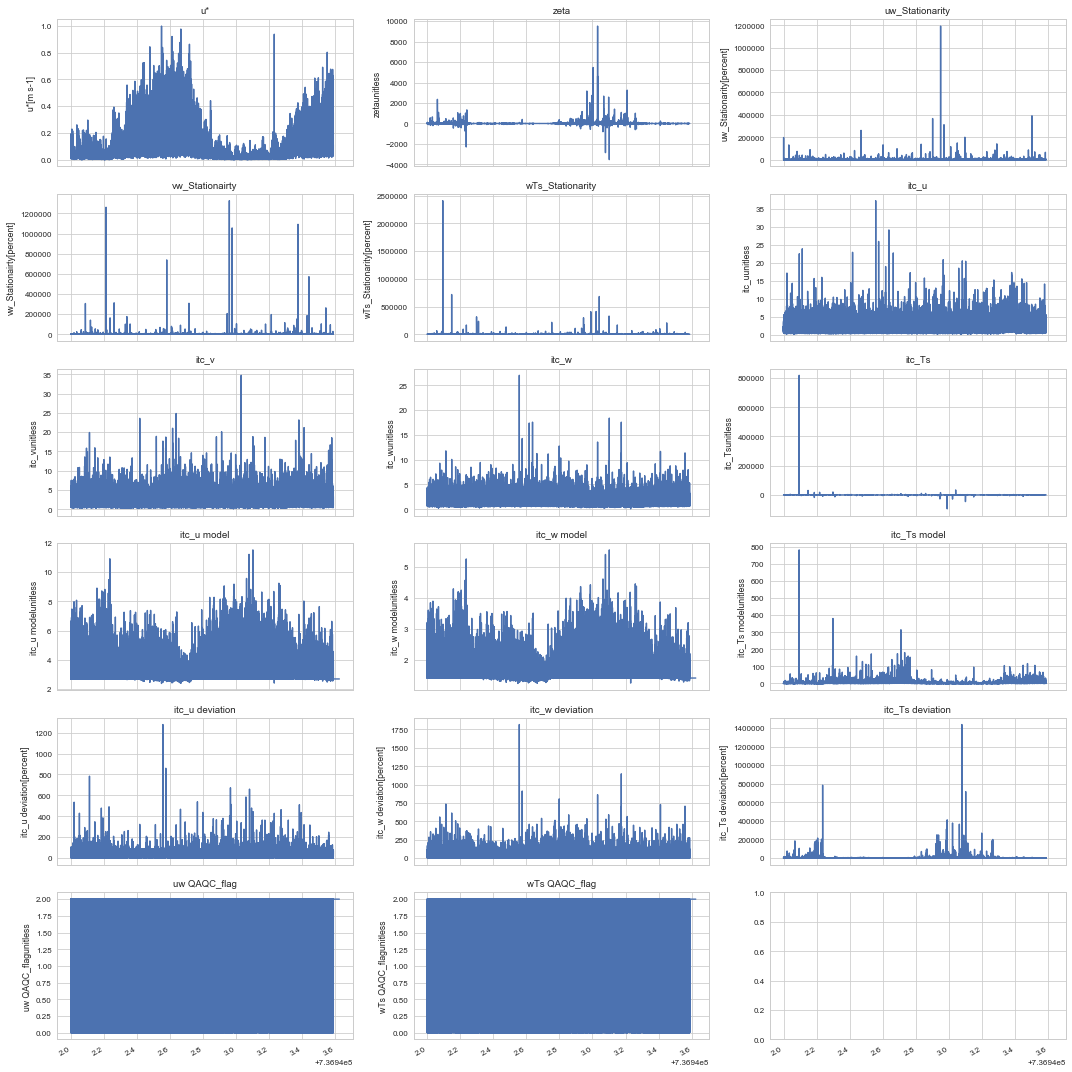

In [11]:
fig, axes = plt.subplots(6, 3, sharex=True, figsize=(15, 15))
axes = axes.flatten()

siteMetaData = ['Latitude', 'Coriolis_param f']
qaqcPlotItems = [col for col in qaqc_df.columns if col not in siteMetaData]

for n, q in enumerate(qaqcPlotItems):
    ax = axes[n]
    ax.plot(qaqc_df.index, qaqc_df[q])
    ax.set_ylabel(q + qaqc_units[q])
    ax.set_title(q)
fig.autofmt_xdate()
fig.tight_layout()

## Format results

In [12]:
# File names
allResults = ['VHSRE_results_1s_3Drot_frc_DOY' + str(DOY) + '.csv'
              for DOY in filenameSuffix]

# Units (names + units = first two rows)
results_cols = pd.read_csv(allResults[0], header=0, delimiter=',',
                           error_bad_lines=False, warn_bad_lines=False, nrows=2)
results_units = results_cols.iloc[0]

# Read all data
resultsList = []

# Loop through files
for rFiles in allResults:
    print(rFiles)
    df = pd.read_csv(rFiles, header=None, delimiter=',', skiprows=[0,1],
                     names=results_cols.columns.values, index_col=False)
    # Drop datetime_end column
    df.drop(['Datetime_start', 'Datetime_end', 'DOY'],
            axis=1, inplace=True)
    resultsList.append(df)
results_df = pd.concat(resultsList)
results_df = results_df.reset_index(drop=True).\
                set_index([matlabdn2datetime(results_df['Datetime_center'].values)])
results_df.drop(['Datetime_center'], axis=1, inplace=True)
results_df.sort_index(inplace=True)

 # Save units as separate dictionary
for ru in results_units.keys():
    if '[1]' in results_units[ru]:
        results_units[ru] = 'unitless'

VHSRE_results_1s_3Drot_frc_DOY247.csv
VHSRE_results_1s_3Drot_frc_DOY247_5.csv
VHSRE_results_1s_3Drot_frc_DOY248.csv
VHSRE_results_1s_3Drot_frc_DOY248_5.csv


/anaconda/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


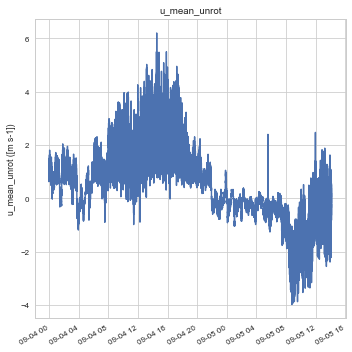

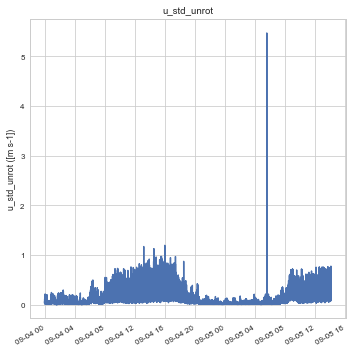

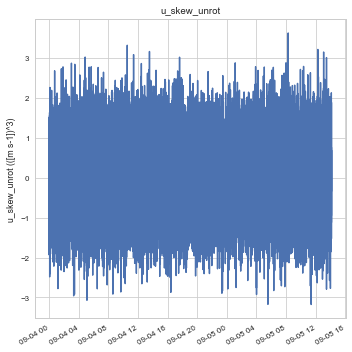

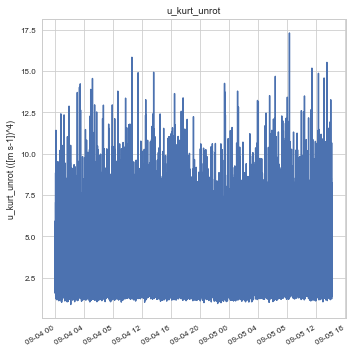

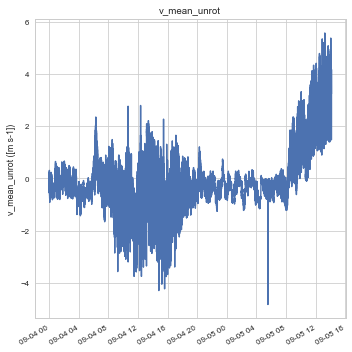

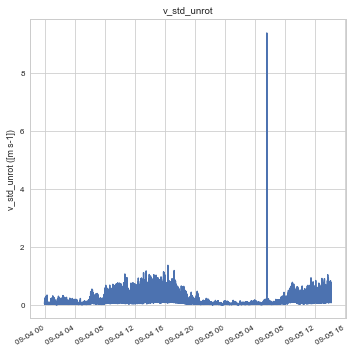

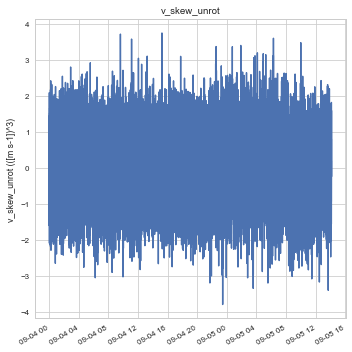

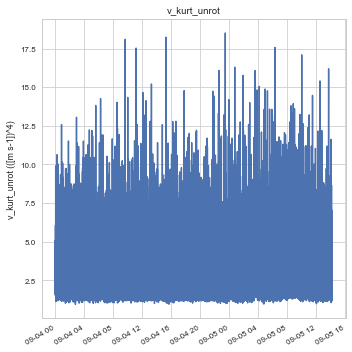

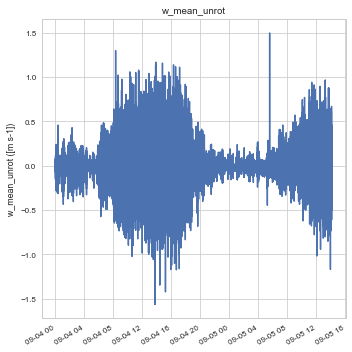

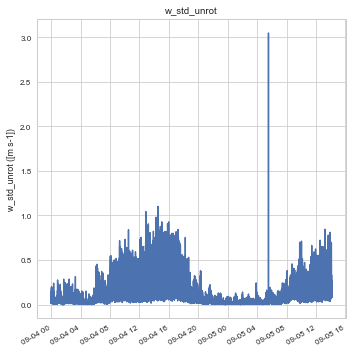

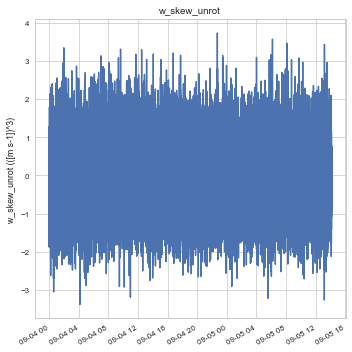

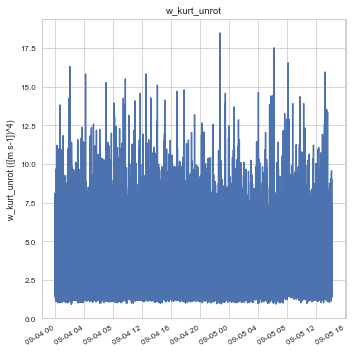

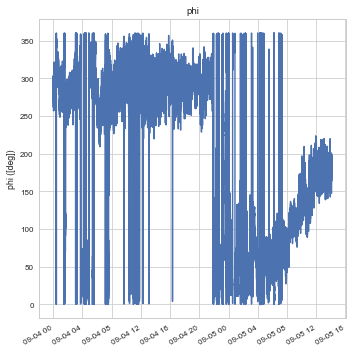

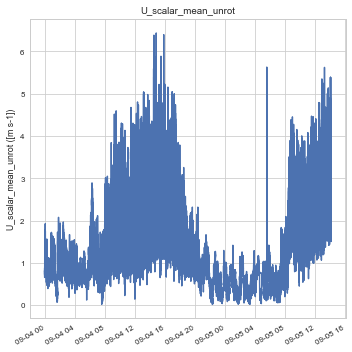

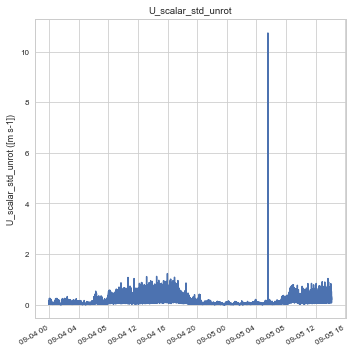

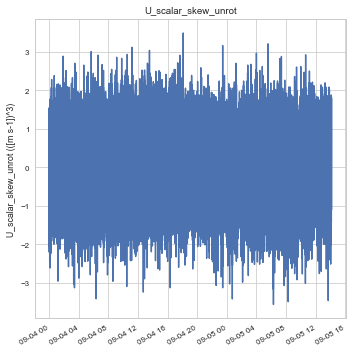

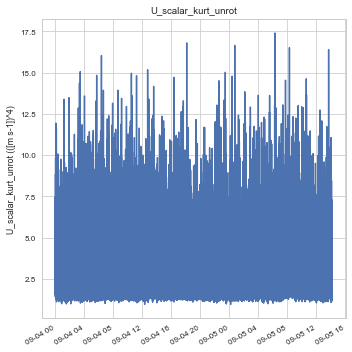

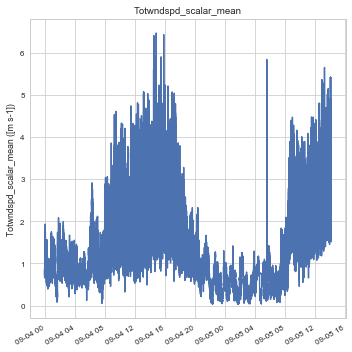

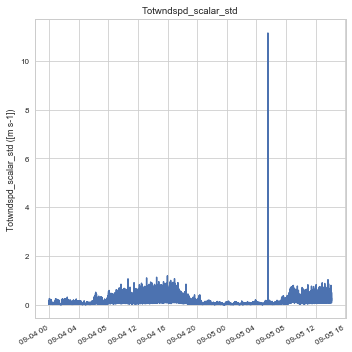

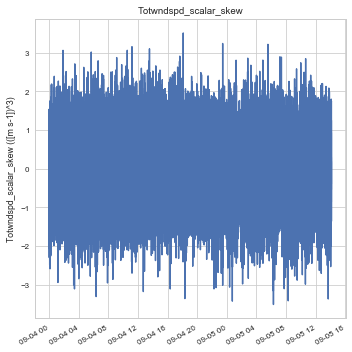

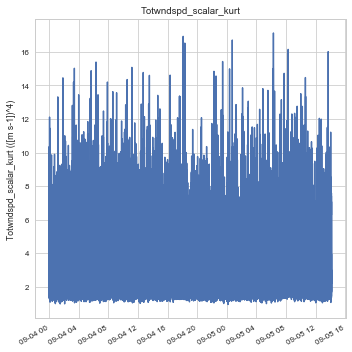

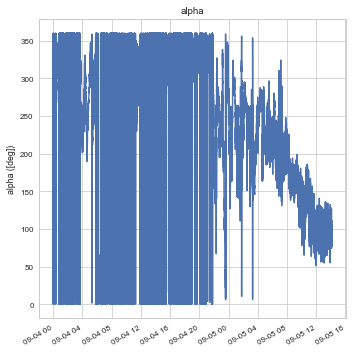

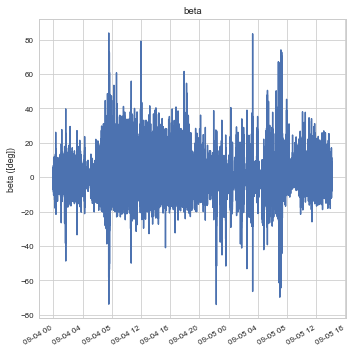

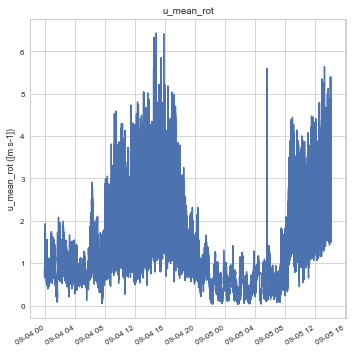

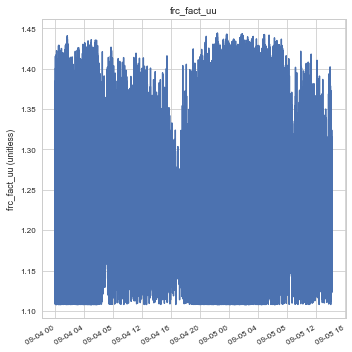

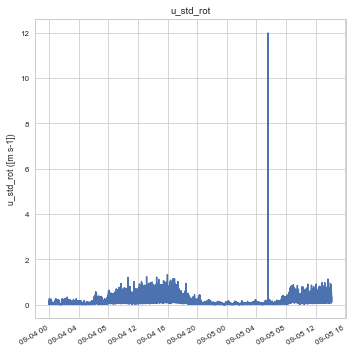

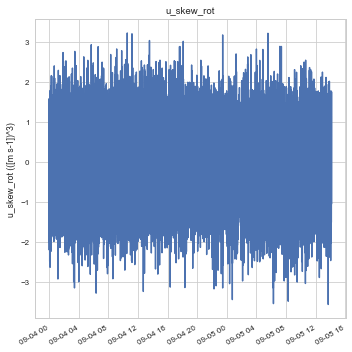

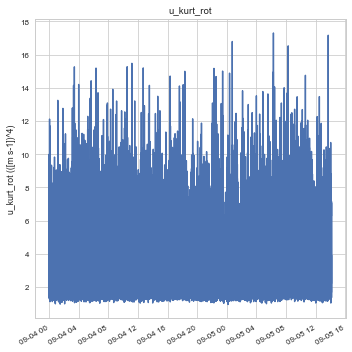

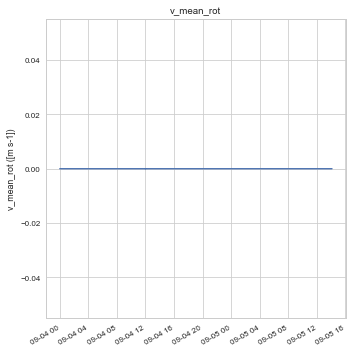

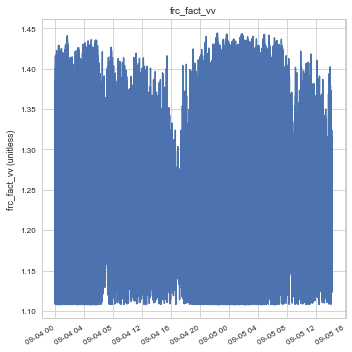

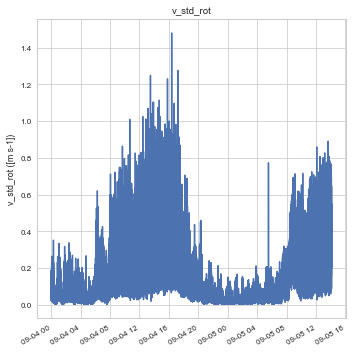

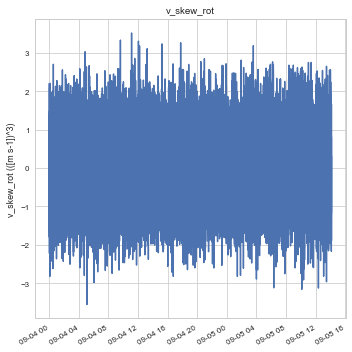

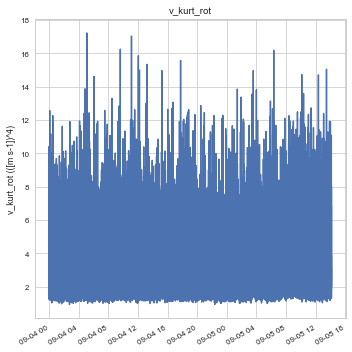

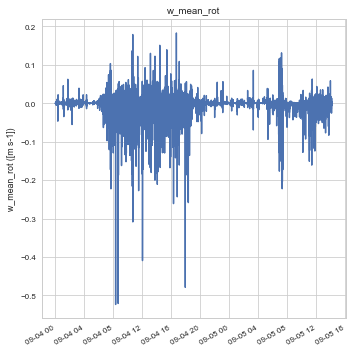

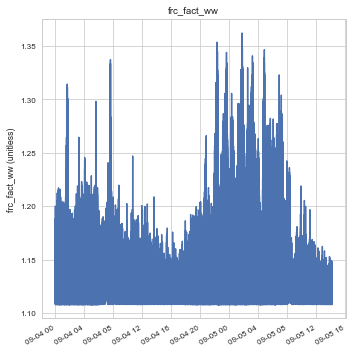

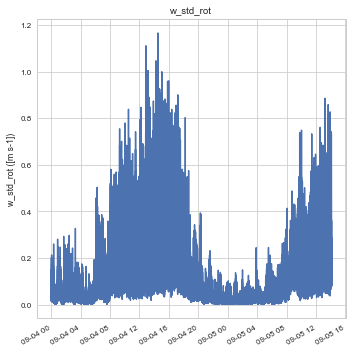

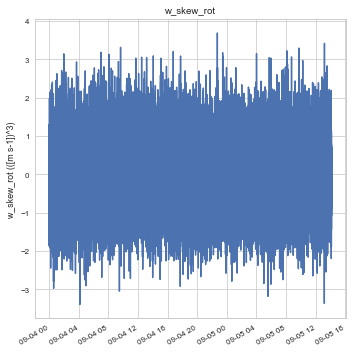

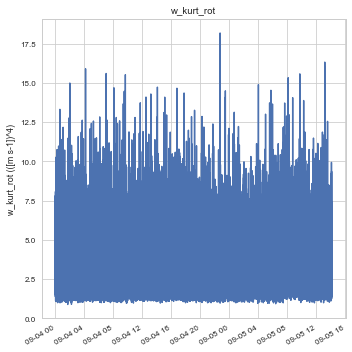

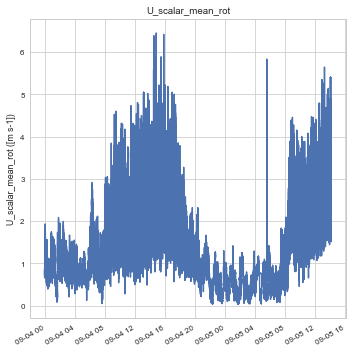

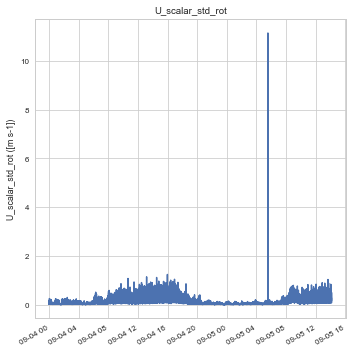

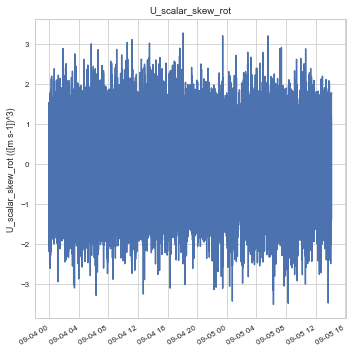

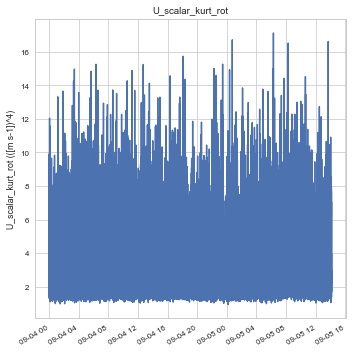

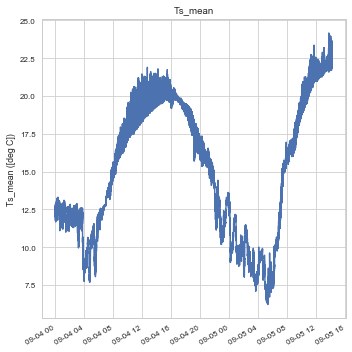

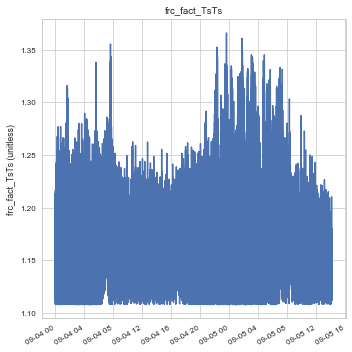

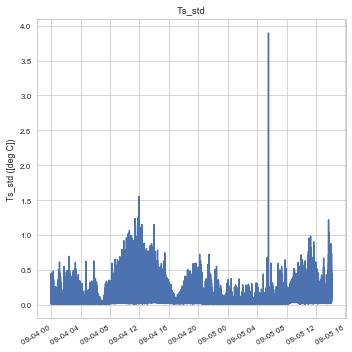

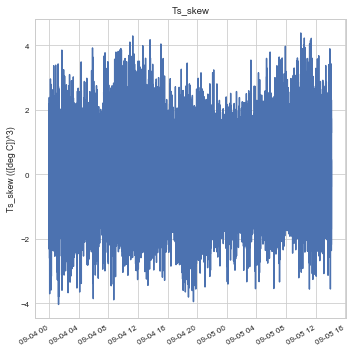

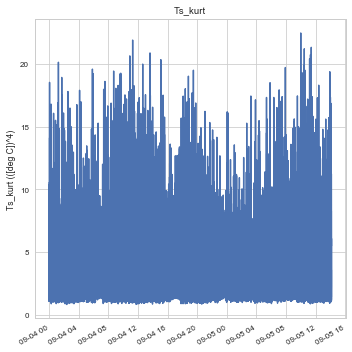

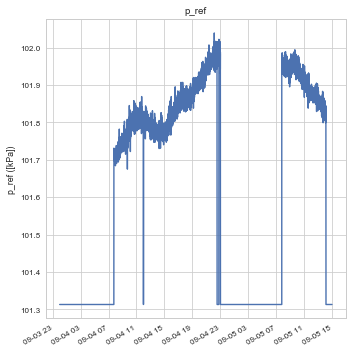

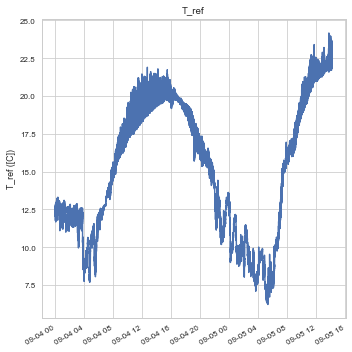

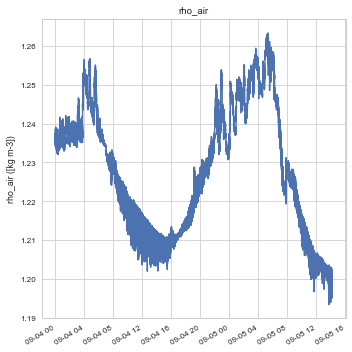

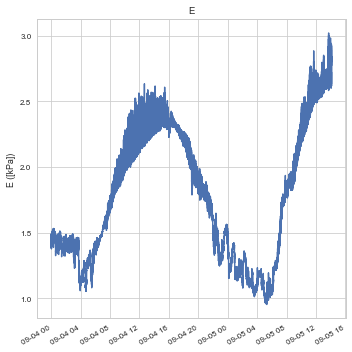

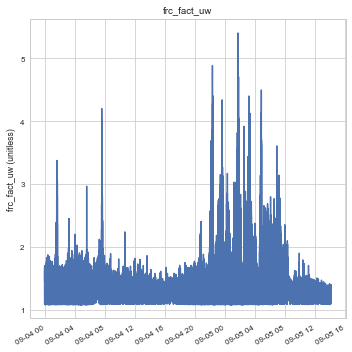

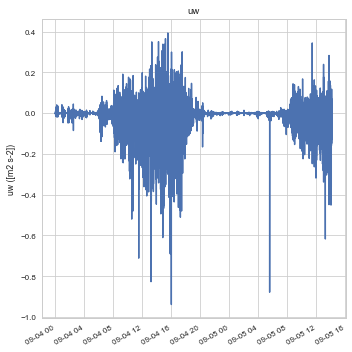

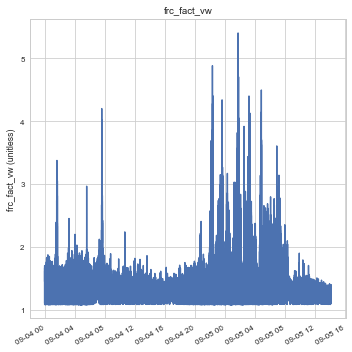

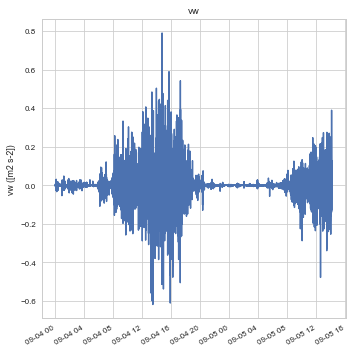

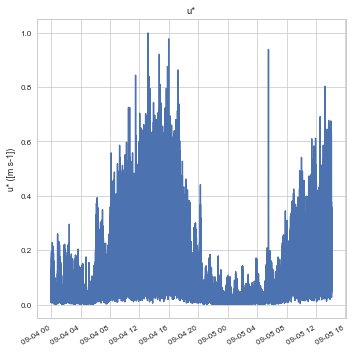

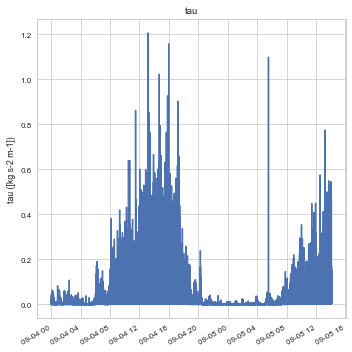

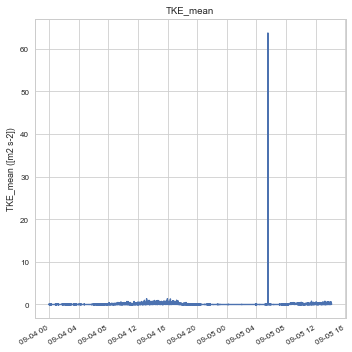

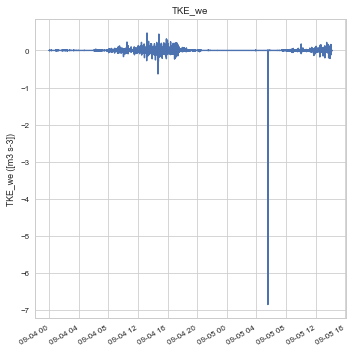

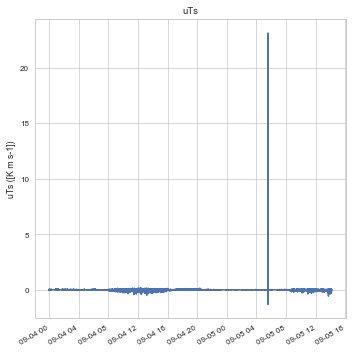

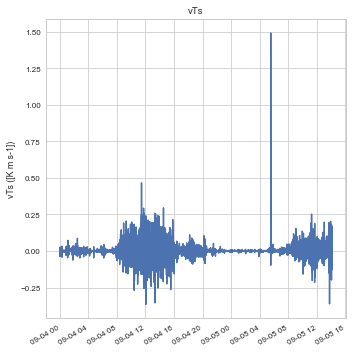

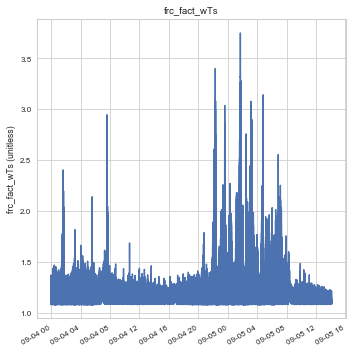

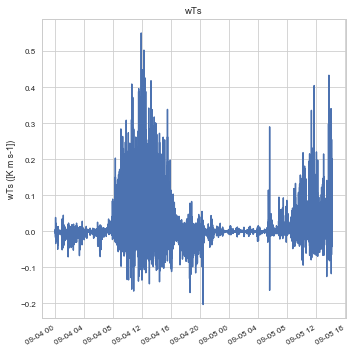

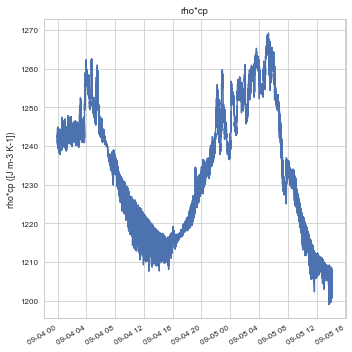

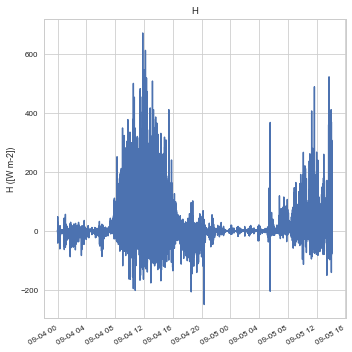

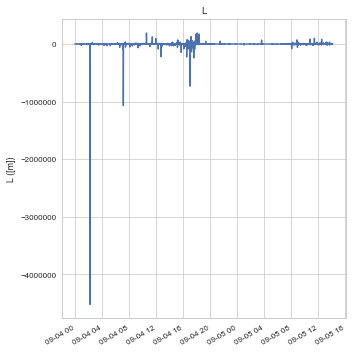

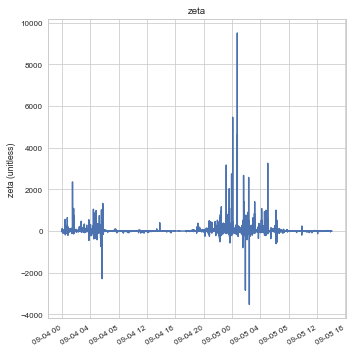

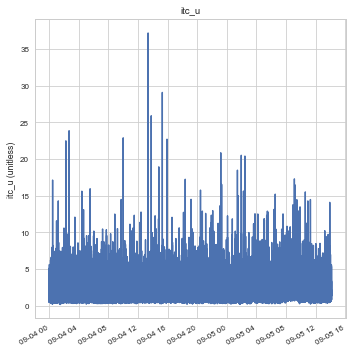

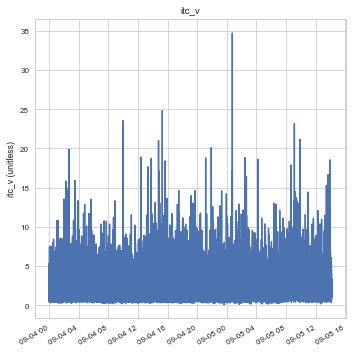

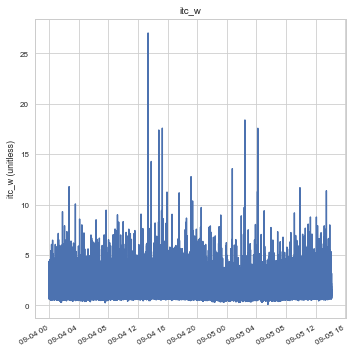

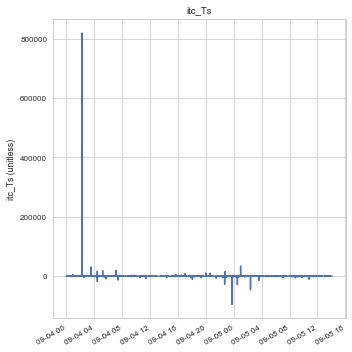

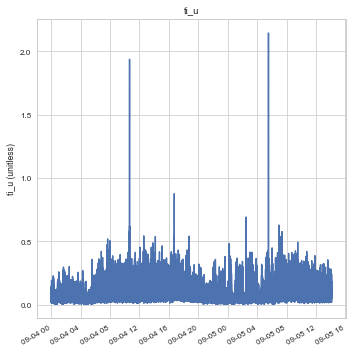

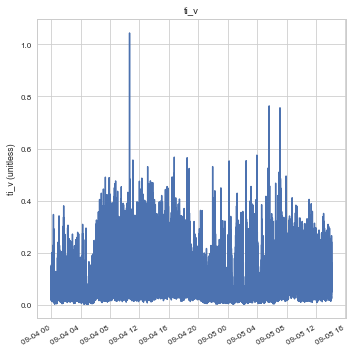

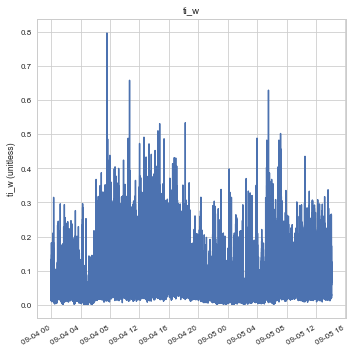

In [13]:
siteMetaData = ['z_asl', 'lat', 'lon', 'utc_offset', 'zenith', 'azimuth', 'z_aero',
                'DayNightIndicator', '#_data', '#_NaN_uvwTs', 'frc_#iterations', '#_lag_wTs']
resultsPlotItems = [col for col in results_df.columns if col not in siteMetaData]

for n, r in enumerate(resultsPlotItems):
    fig, ax = plt.subplots(1, 1, sharex=True, figsize=(5, 5))
    ax.plot(results_df.index, results_df[r])
    ax.set_ylabel(r + ' (' + results_units[r]  + ')')
    ax.set_title(r)
    fig.autofmt_xdate()
    fig.tight_layout()